## Creating tear sheets with Alphalens

In the previous lesson, you learned what Alphalens is. In this lesson, you will learn a four step process for how to use it:
1. Express an alpha factor and define a trading universe by creating and running a pipeline over a certain time period.
2. Query pricing data for the assets in our universe during that same time period with `get_pricing()`
3. Align the alpha factor data with the pricing data with `get_clean_factor_and_forward_returns()`
4. Visualize how well our alpha factor predicts future price movements with `create_full_tear_sheet()`

## Build And Run A Pipeline
The following code expresses an alpha factor based on asset growth, then runs it with `run_pipeline()`

In [1]:
from zipline.pipeline.fundamentals import Fundamentals

from zipline.pipeline import Pipeline
from zipline.research import run_pipeline
from zipline.pipeline.builtin import QTradableStocksUS

def make_pipeline():

    # Measures a company's asset growth rate.
    asset_growth = Fundamentals.financial_indicators.总资产增长率.latest 

    return Pipeline(
      columns={'asset_growth': asset_growth},
      screen=QTradableStocksUS() & asset_growth.notnull()
    )

factor_data = run_pipeline(pipeline=make_pipeline(), start_date='2014-1-1', end_date='2016-1-1')

# Show the first 5 rows of factor data
factor_data.head(5)

asset_growth
2014-01-02 00:00:00+00:00 平安银行(000001)        15.504
                          万 科Ａ(000002)        21.736
                          国农科技(000004)        12.284
                          世纪星源(000005)       -13.359
                          深振业Ａ(000006)        15.870

## Query Pricing Data
Now that we have factor data, let's get pricing data for the same time period. `get_pricing()` returns pricing data for a list of assets over a specified time period. It requires four arguments: 

1. A list of assets for which we want pricing.
2. A start date.
3. An end date.
4. Whether to use open, high, low or close pricing.

In [2]:
from zipline.research import get_pricing

In [3]:
pricing_data = get_pricing(
  factor_data.index.levels[1], # Finds all assets that appear at least once in "factor_data"  
  start_date='2014-1-1',
  end_date='2016-10-1', # must be after run_pipeline()'s end date. Explained more in lesson 4
  fields='open' # Generally, you should use open pricing. Explained more in lesson 4
)

We now have pricing data for every asset in our trading universe. The first five rows look like this: 

In [4]:
# Show the first 5 rows of pricing_data
pricing_data.head(5)

,平安银行(000001),万 科Ａ(000002),国农科技(000004),世纪星源(000005),深振业Ａ(000006),全新好(000007),神州高铁(000008),中国宝安(000009),*ST美丽(000010),深物业A(000011),...,龙韵股份(603729),隆鑫通用(603766),XD宁波高(603788),福斯特(603806),新澳股份(603889),晨光文具(603899),银龙股份(603969),中电电机(603988),洛阳钼业(603993),继峰股份(603997)
open,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00+00:00,6.757,7.033,11.64,2.50,4.657,13.90,2.069,5.735,7.77,7.332,...,NaN,8.971,NaN,NaN,NaN,NaN,NaN,NaN,2.081,NaN
2014-01-03 00:00:00+00:00,6.774,7.015,11.70,2.49,4.572,14.04,2.064,5.765,8.08,7.389,...,NaN,8.952,NaN,NaN,NaN,NaN,NaN,NaN,2.030,NaN
2014-01-06 00:00:00+00:00,6.629,6.883,11.77,2.44,4.478,14.13,2.071,5.600,7.51,7.161,...,NaN,8.589,NaN,NaN,NaN,NaN,NaN,NaN,2.004,NaN
2014-01-07 00:00:00+00:00,6.428,6.540,12.00,2.39,4.204,14.04,1.956,5.508,7.13,6.916,...,NaN,8.455,NaN,NaN,NaN,NaN,NaN,NaN,1.924,NaN
2014-01-08 00:00:00+00:00,6.490,6.557,12.20,2.43,4.204,14.41,1.929,5.533,7.24,6.963,...,NaN,8.684,NaN,NaN,NaN,NaN,NaN,NaN,1.940,NaN


## Align Data
`get_clean_factor_and_forward_returns()` aligns factor data from a Pipeline with pricing data from `get_pricing()`, and returns an object suitable for analysis with Alphalens' charting functions. It requires two arguments: 
1. The factor data we created with run_pipeline().
2. The pricing data we created with get_pricing().

In [5]:
from alphalens.utils import get_clean_factor_and_forward_returns

merged_data = get_clean_factor_and_forward_returns(
  factor=factor_data, 
  prices=pricing_data
)

# Show the first 5 rows of merged_data
merged_data.head(5)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       10D  factor  \
date                      asset                                                
2014-01-02 00:00:00+00:00 平安银行(000001)  0.002516 -0.035371 -0.037887  15.504   
                          万 科Ａ(000002) -0.002559 -0.070098 -0.101379  21.736   
                          国农科技(000004)  0.005155  0.051546 -0.002577  12.284   
                          世纪星源(000005) -0.004000 -0.040000 -0.068000 -13.359   
                          深振业Ａ(000006) -0.018252 -0.107580 -0.127765  15.870   

                                        factor_quantile  
date                      asset                          
2014-01-02 00:00:00+00:00 平安银行(000001)                4  
                          万 科Ａ(000002)                5  
                          国农科技(000004)                4  
                          世纪星源(000005)                1  
                          深振业Ａ(000006)                5

We have now combined pricing and factor data into a format that can be analyzed to see whether our factor data affects prices at certain time periods in the future. By default, those time periods are 1 day, 5 days, and 10 days. 

## Visualize Results
Finally, pass the output of `get_clean_factor_and_forward_returns()` to `create_full_tear_sheet()`. 

分位数统计


,最小值,最大值,平均值,标准差,计数,百分比 %
factor_quantile,,,,,,
1,-93.579,0.380,-6.054263,6.163682,163211,20.027020
2,-2.151,5.608,0.538434,1.655715,162890,19.987631
3,-0.015,10.966,4.103403,2.657438,162909,19.989963
4,1.788,21.872,8.807001,4.532677,162871,19.985300
5,4.566,4146.249,32.214243,63.611751,163073,20.010086


收益率分析


,1D,5D,10D
Ann. alpha,0.016,-0.001,-0.007
beta,-0.038,-0.039,-0.028
最高分位数周期平均收益率(基点),-0.659,-0.880,-0.878
最低分位数周期平均收益率(基点),1.327,1.144,1.169
周期平均展布(基点),-1.985,-2.030,-2.051


<Figure size 1200x800 with 0 Axes>

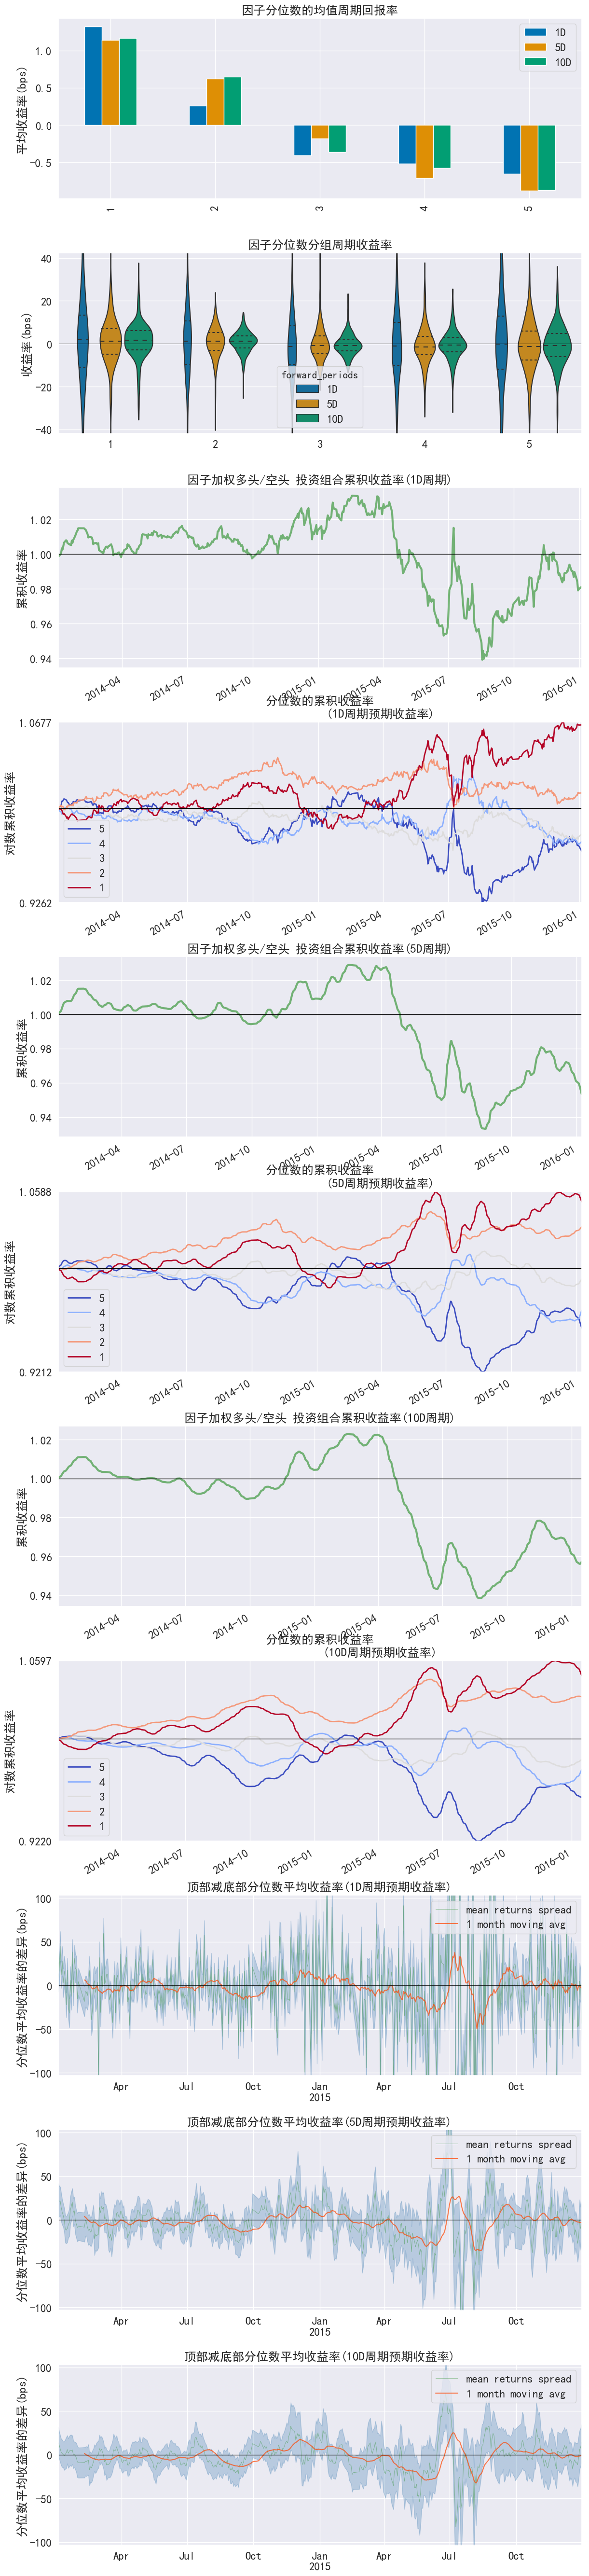

信息系数分析


,1D,5D,10D
IC平均值,-0.006,-0.011,-0.015
IC标准差,0.052,0.058,0.061
风险调整后的IC,-0.114,-0.193,-0.250
t-统计(IC),-2.530,-4.265,-5.528
p值(IC),0.012,0.000,0.000
IC偏度,-0.110,0.058,0.355
IC峰度,0.381,0.641,0.284


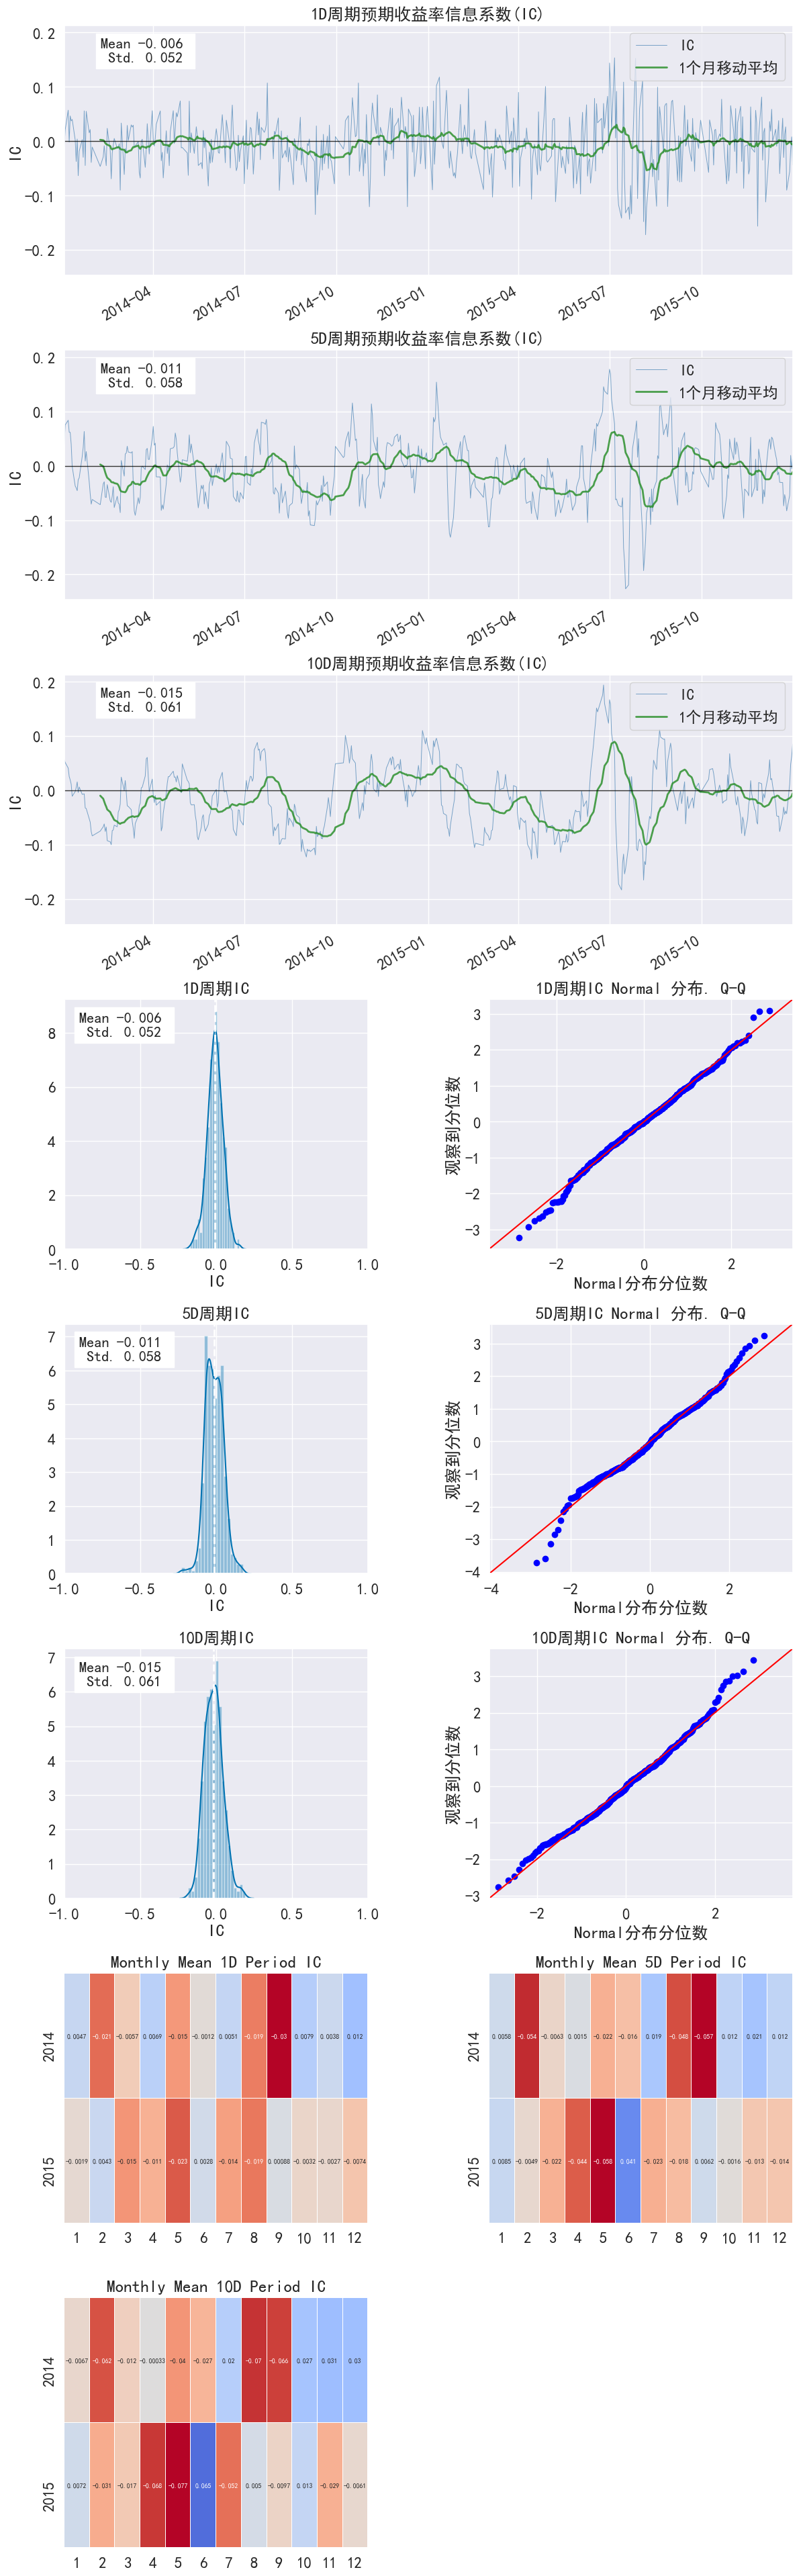

换手率分析


,10D,1D,5D
分位数1平均换手率,0.114,0.014,0.061
分位数2平均换手率,0.156,0.023,0.089
分位数3平均换手率,0.179,0.028,0.106
分位数4平均换手率,0.184,0.029,0.108
分位数5平均换手率,0.142,0.020,0.080


,1D,5D,10D
平均因子秩自相关,0.993,0.965,0.933


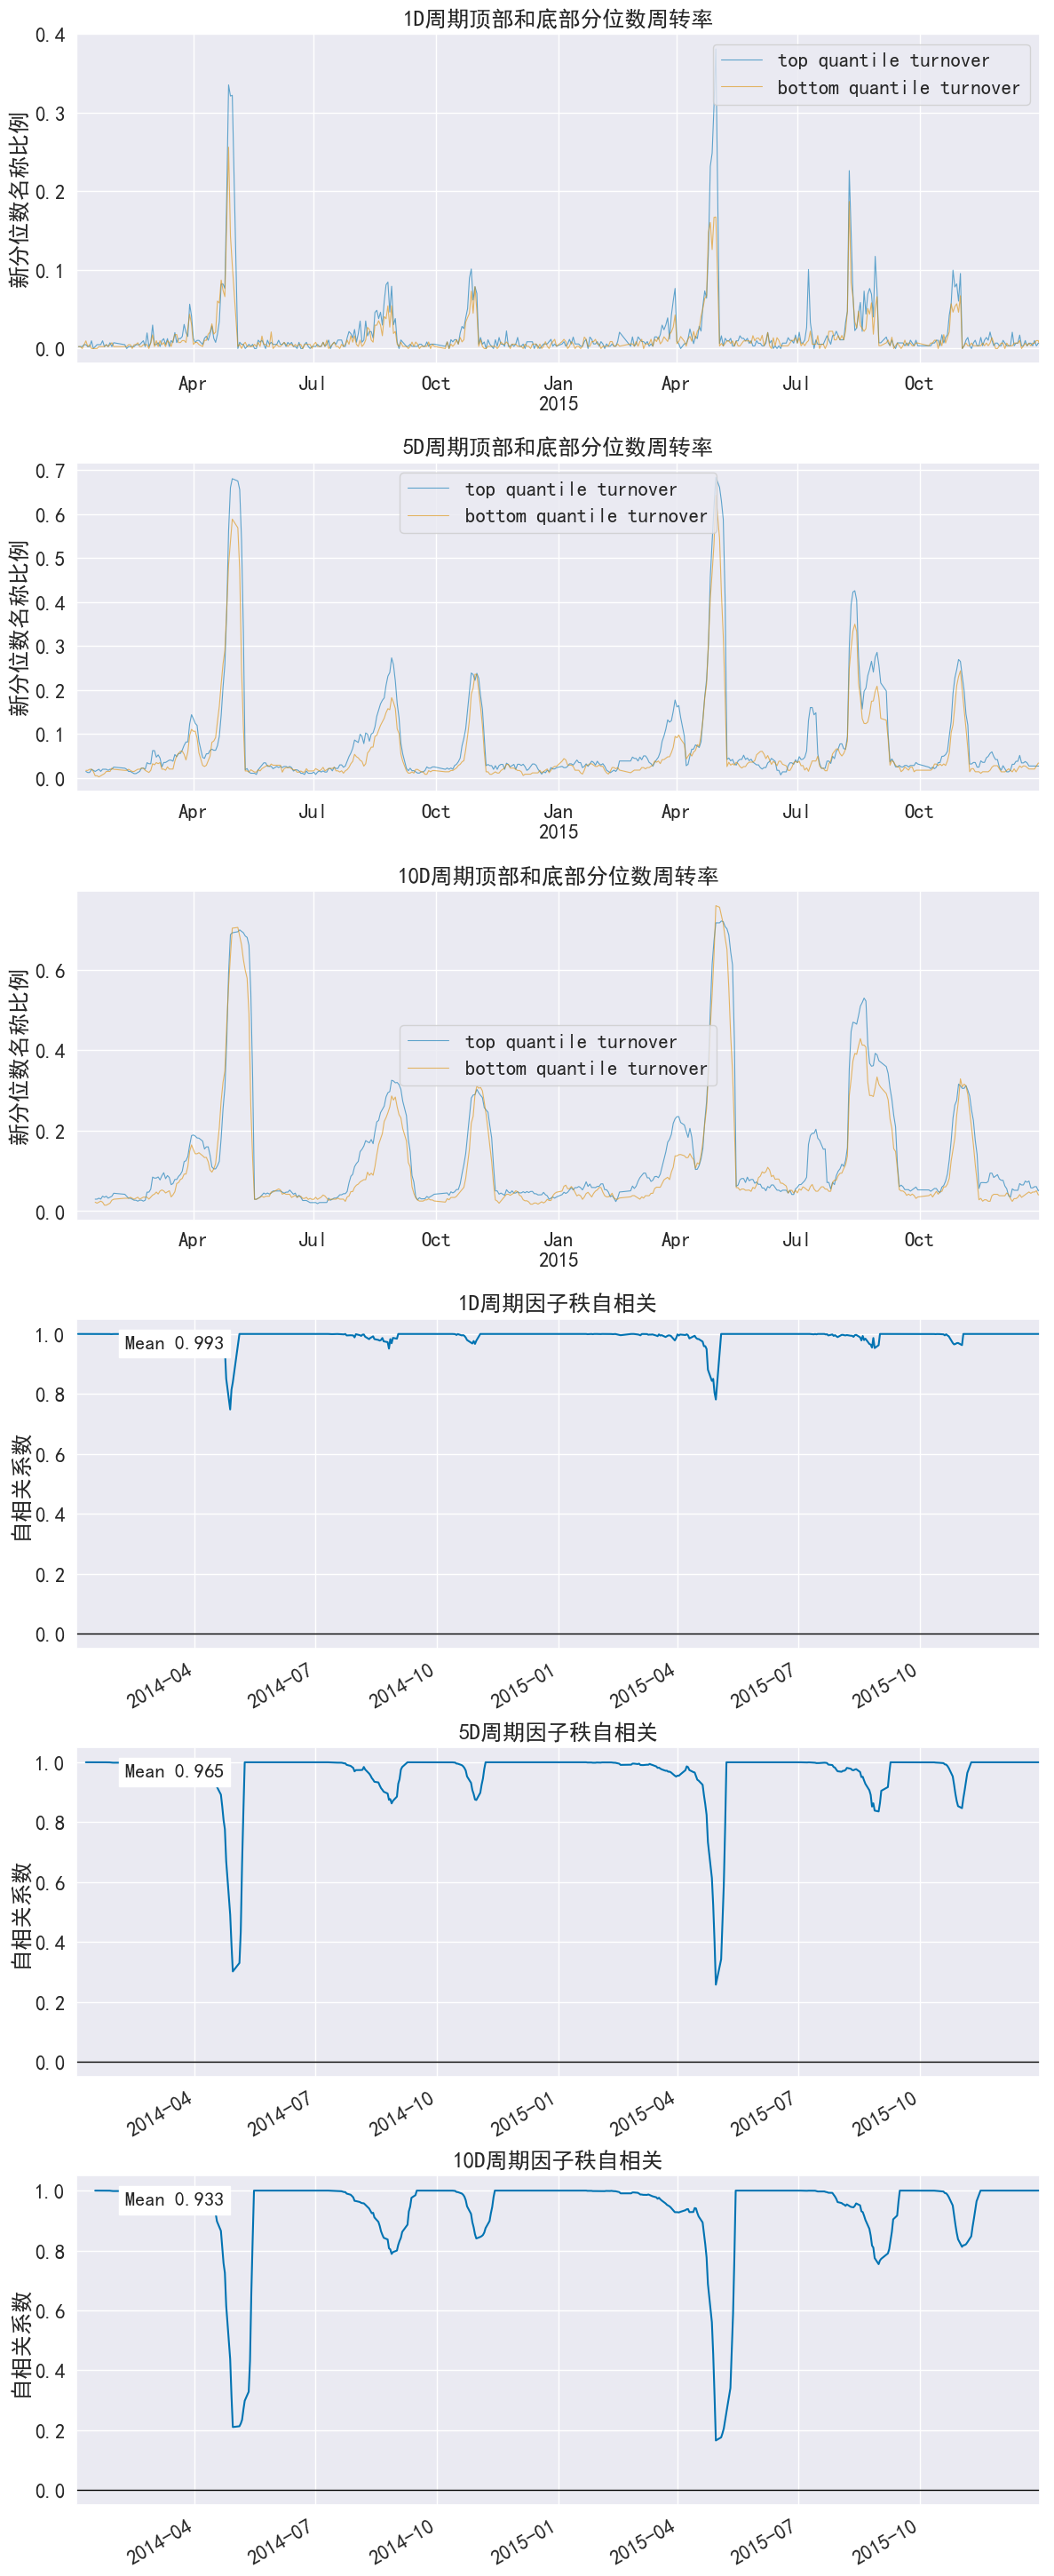

In [6]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(merged_data)

That's It!
In the next lesson, we will show you how to interpret the charts produced by `create_full_tear_sheet()`. 